**APPENDIX K**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
 
import statsmodels.api as sm
 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
 
# Import Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
 
# Import Prophet
from fbprophet import Prophet
# Import VAR Model
from statsmodels.tsa.vector_ar.var_model import VAR
 
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/all_together - Copy.csv')
df.head()

,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET
0,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0
1,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0
2,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0
3,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,0.0
4,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,0.0


In [ ]:
df['date'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: f"{row['year']}-{row['month']}-{row['day']} {row['hour']}:00:00", axis=1)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET,date
0,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,0.0,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,0.0,2013-03-01 04:00:00


In [ ]:

df.drop(['No','year','month','day','hour'], axis=1, inplace=True)
df.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET,date
0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0,2013-03-01 00:00:00
1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0,2013-03-01 01:00:00
2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0,2013-03-01 02:00:00
3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,0.0,2013-03-01 03:00:00
4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,0.0,2013-03-01 04:00:00


In [ ]:
df.sort_values(by='date', inplace=True)
df.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET,date
0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0,2013-03-01 00:00:00
35064,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5,0.0,2013-03-01 00:00:00
1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0,2013-03-01 01:00:00
35065,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,0.7,0.0,2013-03-01 01:00:00
2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0,2013-03-01 02:00:00


In [ ]:
df['date'].min(), df['date'].max()

(Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-28 23:00:00'))

In [ ]:
df.set_index('date', inplace=True)
df.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET
date,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0
2013-03-01 00:00:00,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5,0.0
2013-03-01 01:00:00,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0
2013-03-01 01:00:00,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,0.7,0.0
2013-03-01 02:00:00,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0


In [ ]:
X = df.drop('TARGET',axis=1)
y = df[['TARGET']]

X = np.nan_to_num(X)
y = np.nan_to_num(y)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)

Y = pd.get_dummies(y1).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0) 

In [ ]:
X_train.shape

(39088, 10)

In [ ]:
y_train.shape

(39088, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam


model = Sequential()

model.add(Dense(20,input_shape=(10,),activation='tanh'))
model.add(Dense(8,activation='tanh'))
model.add(Dense(6,activation='tanh'))
model.add(Dense(3,activation='softmax'))

model.compile(Adam(lr=0.004),'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 168       
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 21        
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,batch_size=100, epochs=100,verbose=1, validation_split=0.20)
y_pred = model.predict(X_test)


Epoch 1/100
313/313 [==============================] - 1s 2ms/step - loss: 0.7017 - accuracy: 0.6859 - val_loss: 0.5463 - val_accuracy: 0.7579
Epoch 2/100
313/313 [==============================] - 0s 1ms/step - loss: 0.5386 - accuracy: 0.7723 - val_loss: 0.4999 - val_accuracy: 0.7746
Epoch 3/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4982 - accuracy: 0.7875 - val_loss: 0.4881 - val_accuracy: 0.7896
Epoch 4/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4657 - accuracy: 0.8042 - val_loss: 0.4910 - val_accuracy: 0.8021
Epoch 5/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4823 - accuracy: 0.7934 - val_loss: 0.4796 - val_accuracy: 0.7758
Epoch 6/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4626 - accuracy: 0.8091 - val_loss: 0.4649 - val_accuracy: 0.8078
Epoch 7/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4721 - accuracy: 0.8040 - val_loss: 0.4368 - val_accuracy: 0.8149

In [ ]:
y_pred

array([[1.50440261e-03, 2.40010217e-01, 7.58485377e-01],
       [2.89185941e-01, 7.10484445e-01, 3.29633243e-04],
       [1.50440261e-03, 2.40010217e-01, 7.58485377e-01],
       ...,
       [7.47275352e-03, 9.62168813e-01, 3.03584673e-02],
       [8.90802681e-01, 1.08663626e-01, 5.33663551e-04],
       [1.50440261e-03, 2.40010217e-01, 7.58485377e-01]], dtype=float32)

In [ ]:
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3251
           1       0.80      0.87      0.83      6527
           2       0.85      0.77      0.81      3252

    accuracy                           0.83     13030
   macro avg       0.84      0.81      0.82     13030
weighted avg       0.83      0.83      0.83     13030

[[2582  669    0]
 [ 424 5674  429]
 [   3  743 2506]]


In [ ]:
import seaborn as sns
import pandas as pd
import datetime 
import calendar
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
 

# Model accuracy
print("\n")
print("Normal Predictor Values ===============================")
#print("model score: %.3f" % model.score(X_test, y_test))
print("Accuracy:",metrics.accuracy_score(y_test_class,y_pred_class))
print("Precision:",metrics.precision_score(y_test_class,y_pred_class, average='weighted'))
print("Recall:",metrics.recall_score(y_test_class,y_pred_class, average='weighted'))
print("F1 Score:",metrics.f1_score(y_test_class,y_pred_class, average='weighted'))
print("\n")



Normal Predictor Values ===============================
Accuracy: 0.8259401381427475
Precision: 0.8282972538441749
Recall: 0.8259401381427475
F1 Score: 0.8255731804340203




In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


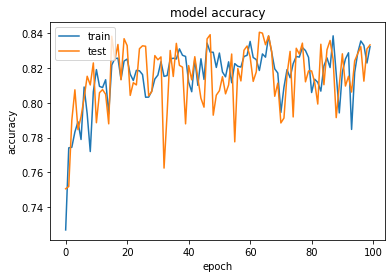

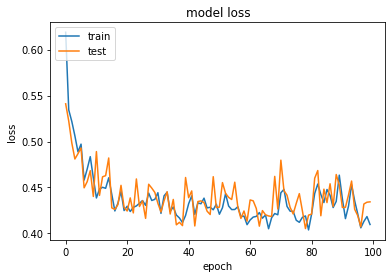

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam


model = Sequential()

model.add(Dense(20,input_shape=(10,),activation='tanh'))
model.add(Dense(8,activation='tanh'))
model.add(Dense(6,activation='tanh'))
model.add(Dense(3,activation='softmax'))

model.compile(SGD(lr=0.004),'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 21        
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,epochs=100,verbose=1, validation_split=0.20)
y_pred = model.predict(X_test)


Epoch 1/100
978/978 [==============================] - 2s 1ms/step - loss: 0.9067 - accuracy: 0.5917 - val_loss: 0.6816 - val_accuracy: 0.6842
Epoch 2/100
978/978 [==============================] - 1s 1ms/step - loss: 0.6895 - accuracy: 0.7011 - val_loss: 0.6521 - val_accuracy: 0.7504
Epoch 3/100
978/978 [==============================] - 1s 1ms/step - loss: 0.6797 - accuracy: 0.7049 - val_loss: 0.6476 - val_accuracy: 0.7174
Epoch 4/100
978/978 [==============================] - 1s 1ms/step - loss: 0.6589 - accuracy: 0.6943 - val_loss: 0.6778 - val_accuracy: 0.6278
Epoch 5/100
978/978 [==============================] - 1s 1ms/step - loss: 0.7074 - accuracy: 0.6573 - val_loss: 0.7209 - val_accuracy: 0.5870
Epoch 6/100
978/978 [==============================] - 1s 1ms/step - loss: 0.7390 - accuracy: 0.5961 - val_loss: 0.7300 - val_accuracy: 0.5569
Epoch 7/100
978/978 [==============================] - 1s 1ms/step - loss: 0.7381 - accuracy: 0.6110 - val_loss: 0.7918 - val_accuracy: 0.6804

In [ ]:
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [ ]:
#from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))




              precision    recall  f1-score   support

           0       0.79      0.85      0.82      3251
           1       0.83      0.71      0.77      6527
           2       0.70      0.85      0.77      3252

    accuracy                           0.78     13030
   macro avg       0.77      0.80      0.78     13030
weighted avg       0.79      0.78      0.78     13030

[[2762  470   19]
 [ 730 4646 1151]
 [  15  470 2767]]


In [ ]:
import seaborn as sns
import pandas as pd
import datetime 
import calendar
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
 

# Model accuracy
print("\n")
print("Normal Predictor Values ===============================")
#print("model score: %.3f" % model.score(X_test, y_test))
print("Accuracy:",metrics.accuracy_score(y_test_class,y_pred_class))
print("Precision:",metrics.precision_score(y_test_class,y_pred_class, average='weighted'))
print("Recall:",metrics.recall_score(y_test_class,y_pred_class, average='weighted'))
print("F1 Score:",metrics.f1_score(y_test_class,y_pred_class, average='weighted'))
print("\n")



Normal Predictor Values ===============================
Accuracy: 0.7808902532617038
Precision: 0.7885342997192001
Recall: 0.7808902532617038
F1 Score: 0.7803258334479013




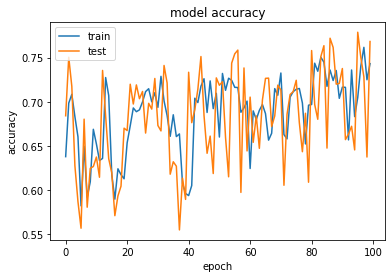

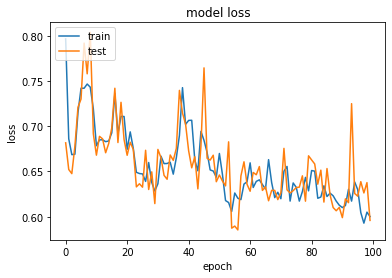

In [ ]:
 # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam


model = Sequential()

model.add(Dense(20,input_shape=(10,),activation='tanh'))
model.add(Dense(8,activation='tanh'))
model.add(Dense(6,activation='tanh'))
model.add(Dense(3,activation='softmax'))

model.compile(RMSprop(lr=0.004),'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 21        
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,batch_size=100, epochs=100,verbose=1, validation_split=0.20)
y_pred = model.predict(X_test)


Epoch 1/100
313/313 [==============================] - 1s 2ms/step - loss: 0.7667 - accuracy: 0.6528 - val_loss: 0.5504 - val_accuracy: 0.7751
Epoch 2/100
313/313 [==============================] - 0s 1ms/step - loss: 0.5450 - accuracy: 0.7622 - val_loss: 0.5189 - val_accuracy: 0.7629
Epoch 3/100
313/313 [==============================] - 0s 1ms/step - loss: 0.5075 - accuracy: 0.7780 - val_loss: 0.4873 - val_accuracy: 0.8003
Epoch 4/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4847 - accuracy: 0.7967 - val_loss: 0.5475 - val_accuracy: 0.7673
Epoch 5/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4886 - accuracy: 0.7964 - val_loss: 0.4275 - val_accuracy: 0.8222
Epoch 6/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4418 - accuracy: 0.8110 - val_loss: 0.4328 - val_accuracy: 0.8162
Epoch 7/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4438 - accuracy: 0.8030 - val_loss: 0.4264 - val_accuracy: 0.8150

In [ ]:
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3251
           1       0.86      0.75      0.80      6527
           2       0.71      0.94      0.81      3252

    accuracy                           0.81     13030
   macro avg       0.81      0.84      0.82     13030
weighted avg       0.83      0.81      0.81     13030

[[2646  592   13]
 [ 386 4905 1236]
 [   3  189 3060]]


In [ ]:
import seaborn as sns
import pandas as pd
import datetime 
import calendar
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
 

# Model accuracy
print("\n")
print("Normal Predictor Values ===============================")
#print("model score: %.3f" % model.score(X_test, y_test))
print("Accuracy:",metrics.accuracy_score(y_test_class,y_pred_class))
print("Precision:",metrics.precision_score(y_test_class,y_pred_class, average='weighted'))
print("Recall:",metrics.recall_score(y_test_class,y_pred_class, average='weighted'))
print("F1 Score:",metrics.f1_score(y_test_class,y_pred_class, average='weighted'))
print("\n")



Normal Predictor Values ===============================
Accuracy: 0.8143514965464314
Precision: 0.8268748949983081
Recall: 0.8143514965464314
F1 Score: 0.8144212393457094




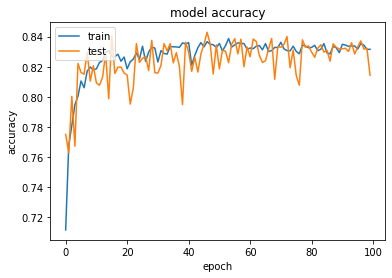

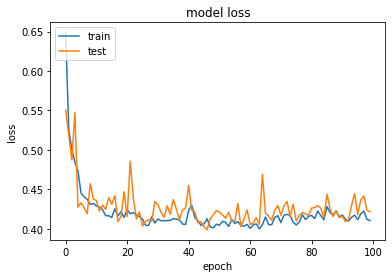

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
